# *Tetrahedra microFE pipeline - trabecular bone*
From micro-CT image to tetrahedra-FE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 15.01.2023 <br />

- By: [Gianluca Iori](https://github.com/gianthk), Martino Pani, [Gianluigi Crimi](https://github.com/gcrimi), Enrico Schileo, Fulvia Taddei, Giulia Fraterrigo, 2023
- Data source: the dataset used in this example is part of the public collection of the Living Human Digital Library (LHDL) Project, a project financed by the European Commission (project number: [FP6-IST 026932](https://cordis.europa.eu/project/id/026932). Human tissues in the LHDL project were collected according to the body donation program of Universitè Libre de Bruxelles (ULB), partner of the project. For info on the dataset see [here](http://projects.kmi.open.ac.uk/lhdl/).
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
# Aims
![](./../../fem_pipeline.png)
The example implements the following ciclope pipeline:
1. Load and inspect microCT volume data
2. Image pre-processing
    - Apply Gaussian smooth (optional)
    - Resample the dataset (optional)
    - Segment bone tissue
    - Remove unconnected clusters of voxels
3. Mesh generation
    - Generate 3D Unstructured Grid mesh of tetrahedra
    - Generate high-resolution mesh of triangles of the model outer shell (optional for visualization)
4. Generate tetrahedra-FE model for simulation in CalculX or Abaqus from 3D Unstructured Grid mesh 
    - Linear, static analysis definition: uniaxial compression test
5. Launch simulation in Calculix. For info on the solver visit the [Calculix homepage](http://www.calculix.de/)
6. Convert Calculix output to .VTK for visualization in Paraview
7. Calculate apparent elastic modulus from reaction forces

---
## Notes on ciclope
* Tetrahedra meshes are generated with [pygalmesh](https://github.com/nschloe/pygalmesh) (a Python frontend to [CGAL](https://www.cgal.org/))
* High-resolution surface meshes for visualization are generated with the [PyMCubes](https://github.com/pmneila/PyMCubes) module.
* All mesh exports are performed with the [meshio](https://github.com/nschloe/meshio) module.
* **ciclope** handles the definition of material properties and FE analysis parameters (e.g. boundary conditions, simulation steps..) through separate template files. The folders [material_properties](https://github.com/gianthk/ciclope/tree/master/material_properties) and [input_templates](https://github.com/gianthk/ciclope/tree/master/input_templates) contain a library of template files that can be used to generate FE simulations.
  * Additional libraries of [CalculiX](https://github.com/calculix) examples and template files can be found [here](https://github.com/calculix/examples) and [here](https://github.com/calculix/mkraska)
___

## Command line execution
The pipeline described in this notebook can be executed from the command line using the **ciclope** command: <br />
```shell
ciclope test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc.inp -vs 0.0195 0.0195 0.0195 -r 2 -t 63 --smooth 1 --tetrafe --max_facet_distance 0.025 --max_cell_circumradius 0.05 --vol_mesh --template input_templates/tmp_example01_comp_static_bone.inp
```

Type `python ciclope.py -h` to display the ciclope help with a full list of available command line arguments.

---
# Computational workflow
## Configuration and imports

In [51]:
import sys
sys.path.append('./../../')

In [52]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology
import meshio

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes
from ciclope.utils.preprocess import remove_unconnected
from ciclope.core import tetraFE
import ciclope

Uncomment and run the following cell for visualizations using [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [53]:
# import vtk
# import itk
# from itkwidgets import view

[ccx2paraview](https://github.com/calculix/ccx2paraview) is needed for the postprocessing of results

In [54]:
import ccx2paraview

In [55]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

#### Load input data

In [56]:
input_file = './../../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Voxel size|19.5 micron|
|Preliminary operations|cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [57]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

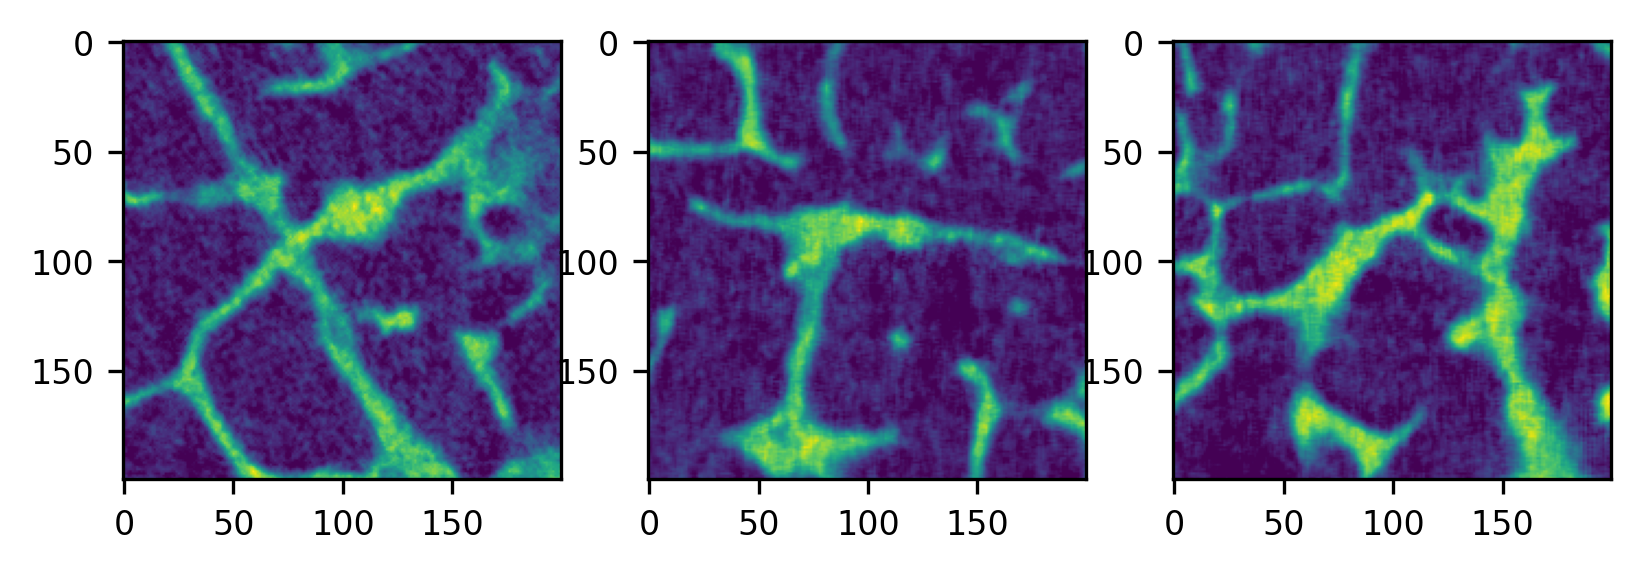

In [58]:
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [59]:
# viewer = view(data_3D, ui_collapsed=True)
# viewer.interpolation = False

Launch the itk viewer

In [60]:
# viewer

![LHDL sample rendering](./../../test_data/LHDL/3155_D_4_bc/LHDL_sample.png)

## Pre-processing
### Gaussian smooth

In [61]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (optional)

In [62]:
resampling = 2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

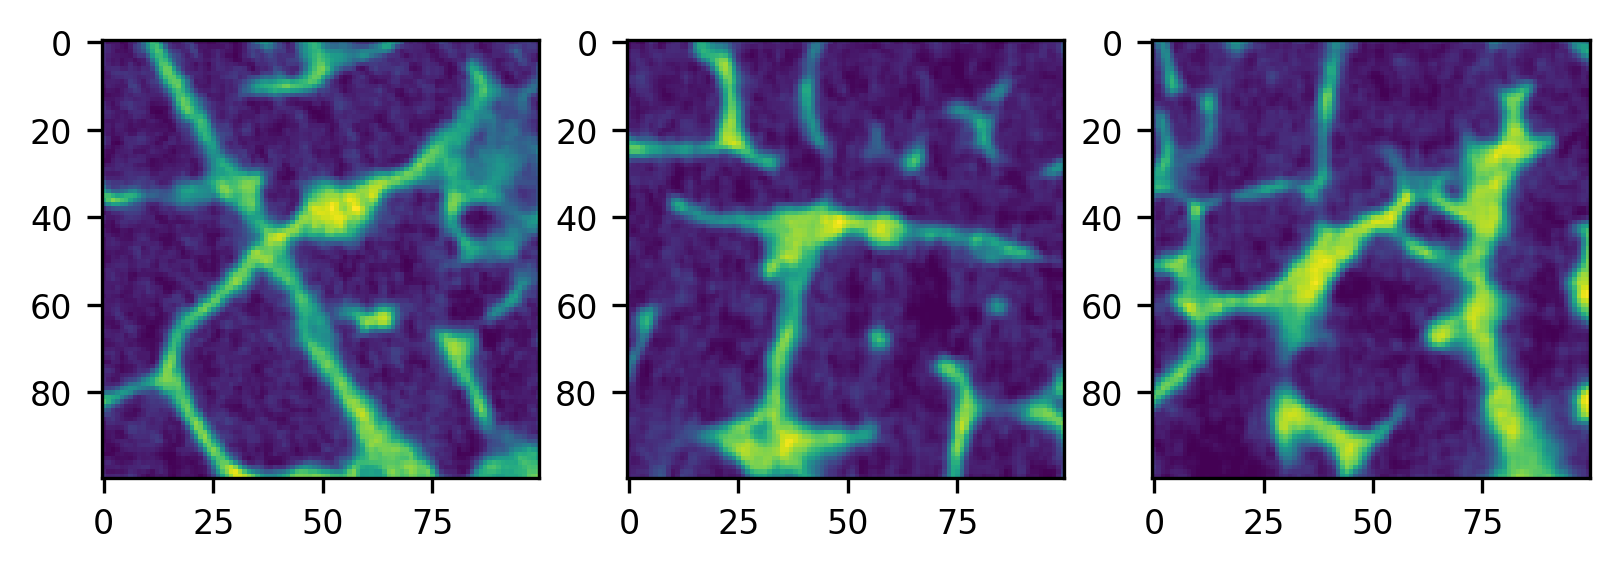

In [63]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding
Use Otsu's method

In [64]:
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 80.72472439570987


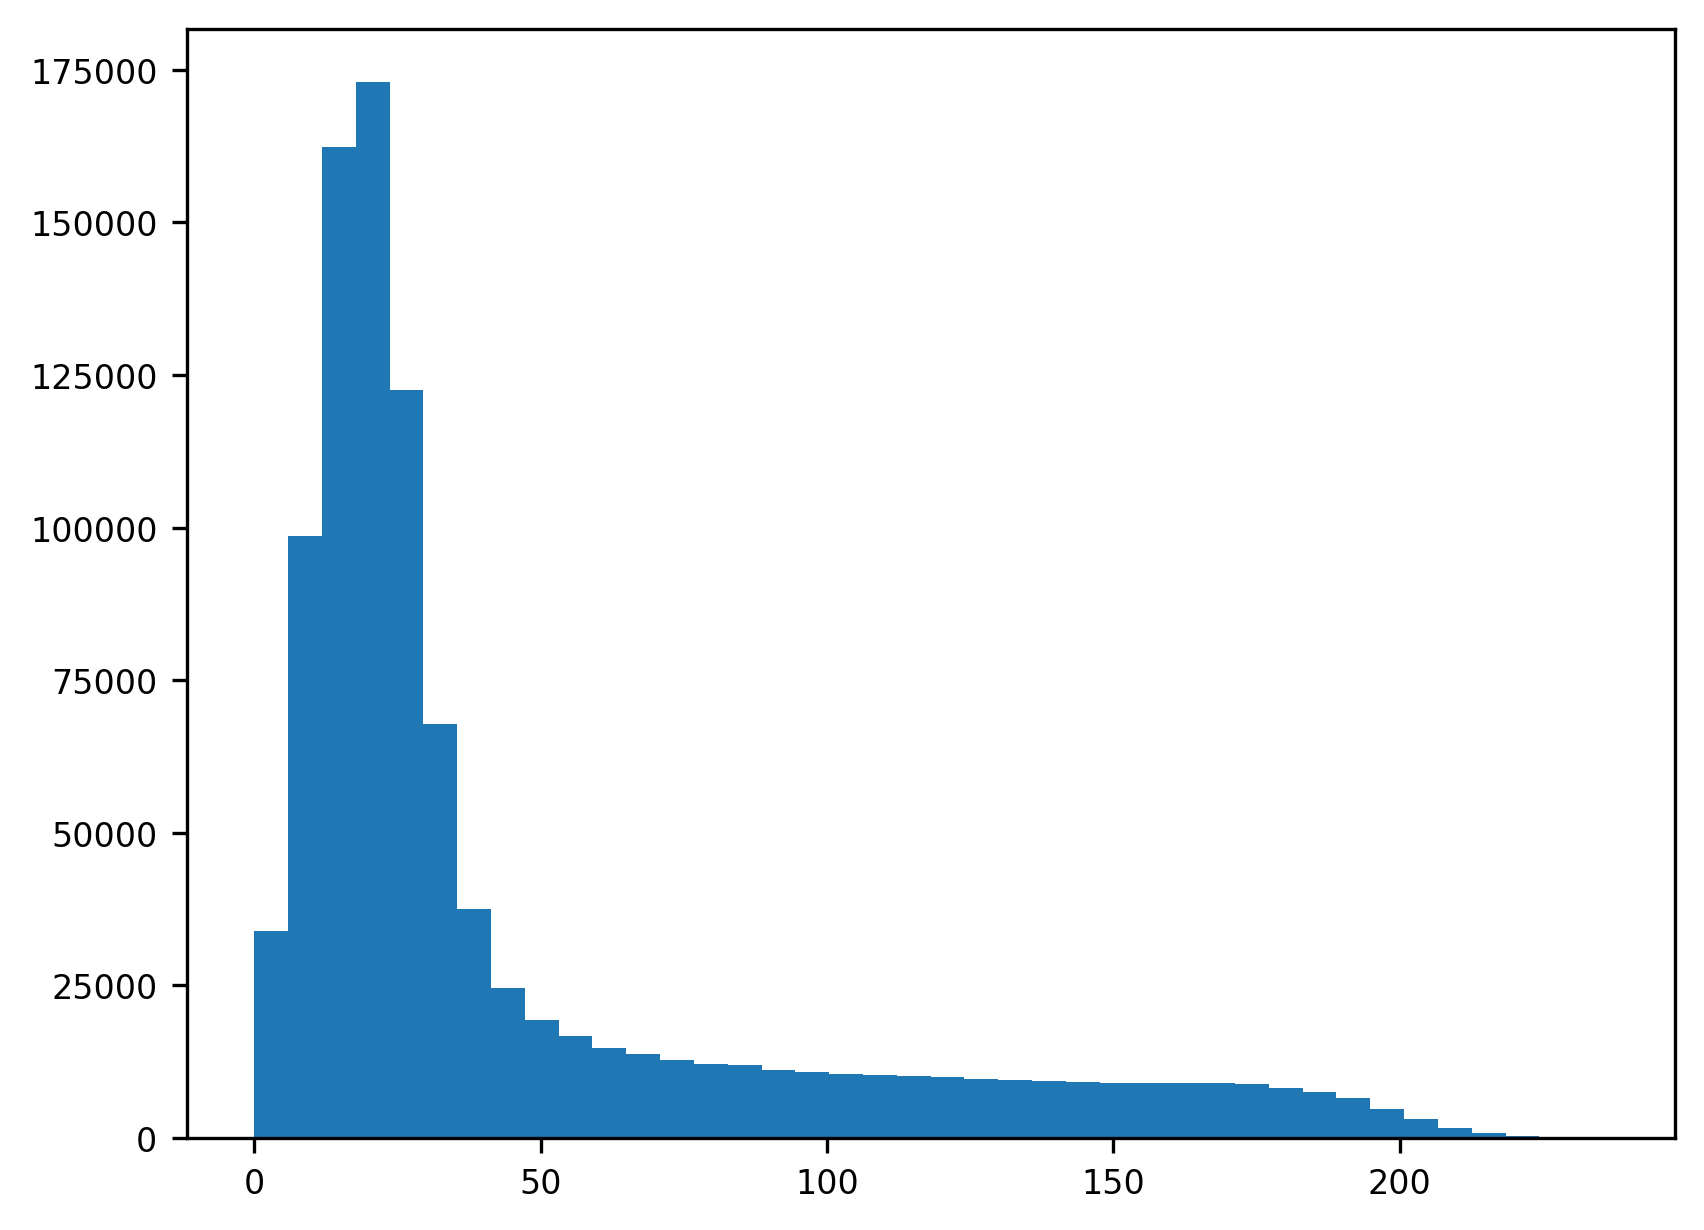

In [65]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply the threshold

In [66]:
# BW = data_3D > T
BW = data_3D > 63 # from comparison with histology

Have a look at the binarized dataset

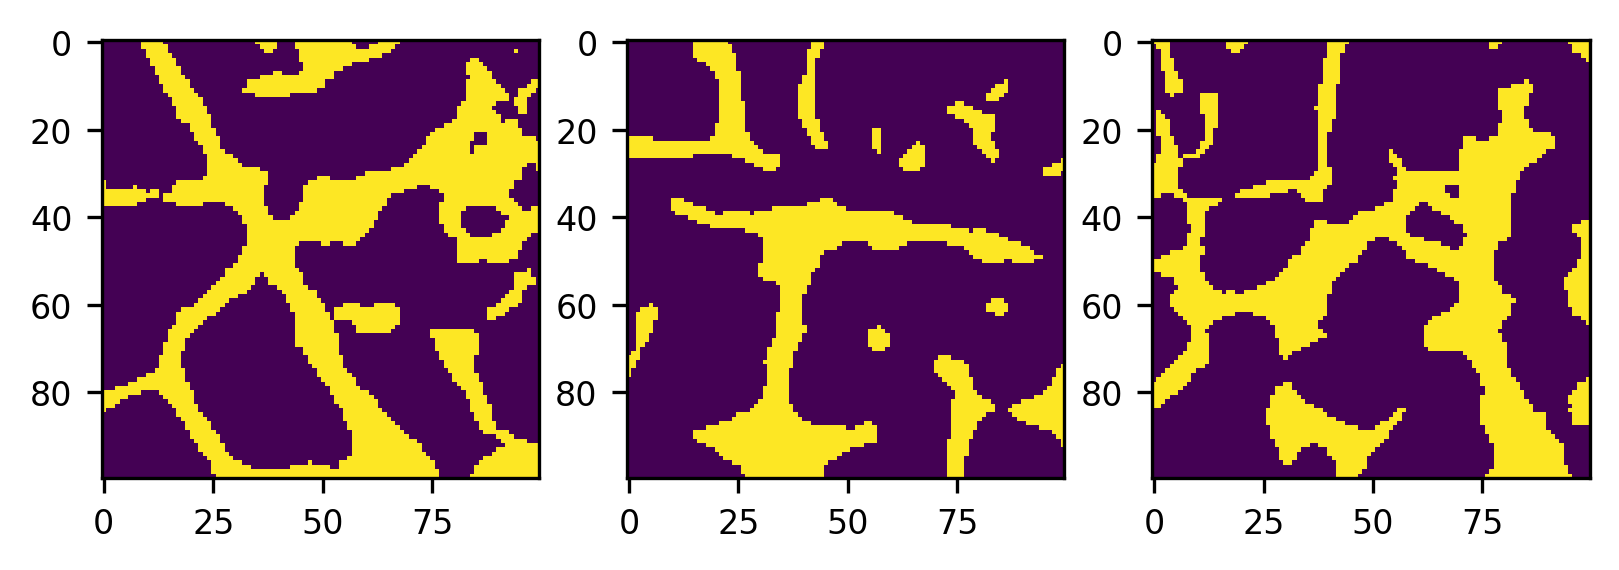

In [67]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [68]:
BW = morphology.closing(BW, morphology.ball(3))

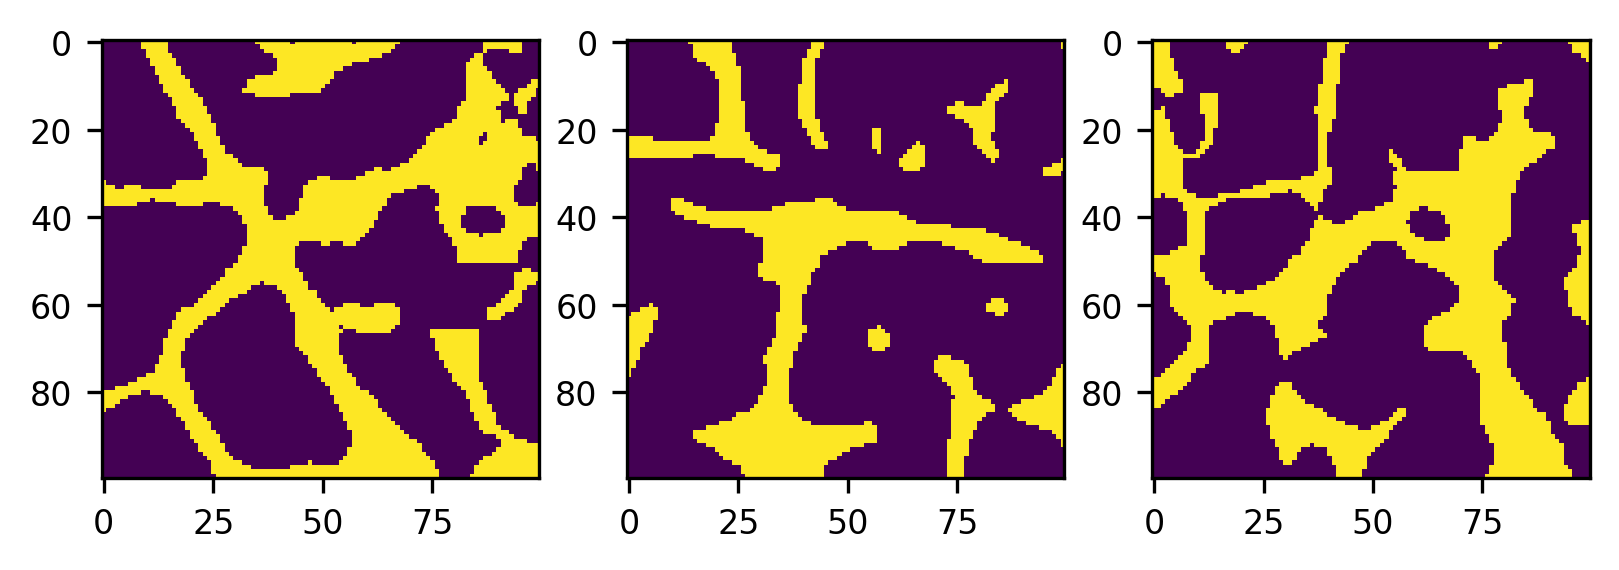

In [69]:
plot_midplanes(BW)
plt.show()

### Detect largest isolated cluster of voxels
The procedure is described by the following 3 steps:
1. Label the BW 3D image

In [70]:
# [labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

2. Count the occurrences of each label

In [71]:
# occurrences = np.bincount(labels.reshape(labels.size))

3. Find the largest unconnected label

In [72]:
# largest_label_id = occurrences[1:].argmax()+1
# L = labels == largest_label_id

You can do the same using the function `remove_unconnected` contained in `ciclope.utils.preprocess'

In [73]:
L = remove_unconnected(BW)

Inspect dataset

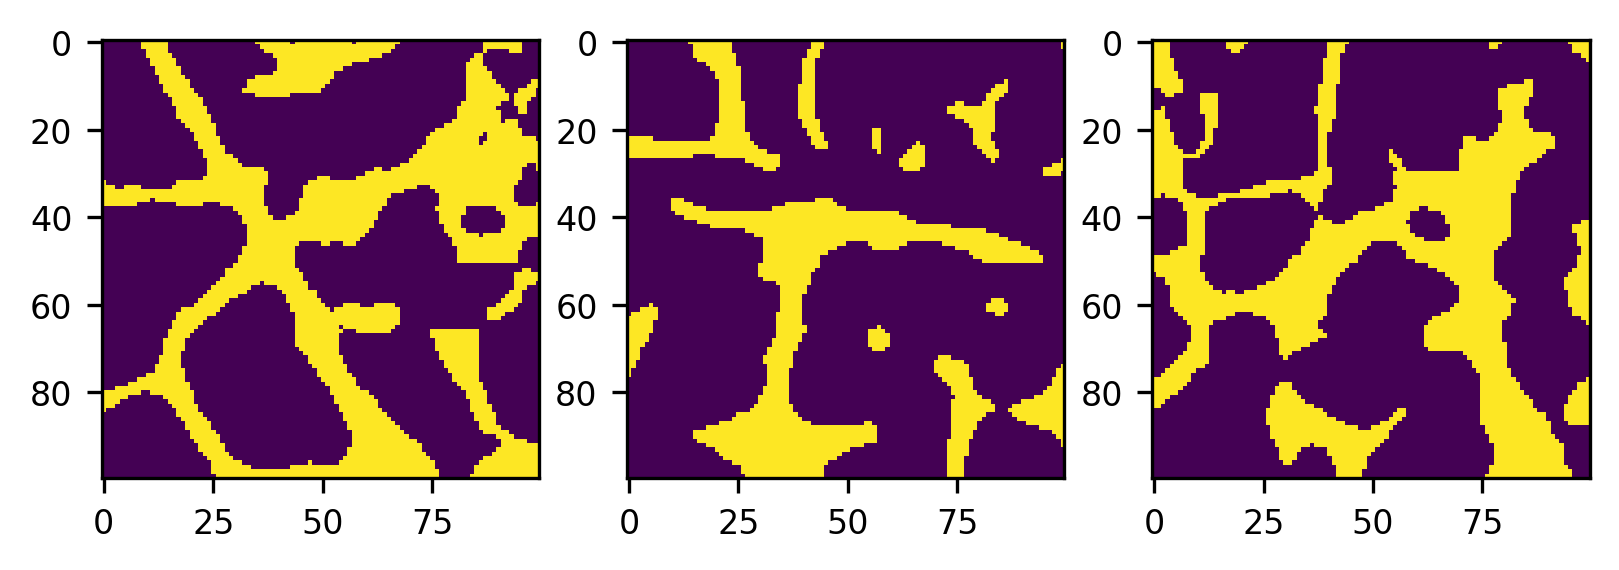

In [74]:
plot_midplanes(L)
plt.show()

## Shell mesh for visualization
**Create a mesh of triangles of the external bone surface (optional)**
Warning: this step is computationally expensive. Only useful for 3D rendering of the bone architecture.
1. Uncomment the following cell to create a shell mesh of triangles

In [75]:
# vertices, triangles, mesh = ciclope.tetraFE.shell_mesh(L, method='pymcubes')

2. Uncomment the following two cells to write the mesh as a VTK file with [meshio](https://github.com/nschloe/meshio)

In [76]:
# filename_shellmesh_out = './../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_shellmesh.vtk'

In [77]:
# meshio.write_points_cells(filename_shellmesh_out, vertices.tolist(), [("triangle", triangles.tolist())])

Visualize the mesh with itkwidgtes

In [78]:
# reader = vtk.vtkUnstructuredGridReader()
# reader.SetFileName(filename_shellmesh_out)
# reader.Update()
# grid = reader.GetOutput()

In [79]:
# view(geometries=grid)

![triangle mesh rendering](./../../test_data/LHDL/3155_D_4_bc/LHDL_shellmesh.png)

### Create tetrahedra mesh
Volume meshing using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [80]:
filename_mesh_out = './../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_tetramesh.vtk'

This is the `pygalmesh` function call

In [81]:
# import pygalmesh
# mesh = pygalmesh.generate_from_array(np.transpose(L, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=1.2*min(vs), max_cell_circumradius=5*1.2*min(vs))

Alternatively use the method `ciclope.core.tetraFE.cgal_mesh`

Reduce `mesh_size_factor` (keeping it small for fast execute)

In [82]:
mesh_size_factor = 5 # 1.2

In [83]:
mesh = tetraFE.cgal_mesh(L, vs, 'tetra', mesh_size_factor*min(vs), 2*mesh_size_factor*min(vs))

construct initial points (nb_points: 12)
12/12 initial point(s) found...
Start surface scan...Scanning triangulation for bad facets (sequential) - number of finite facets = 51...
Number of bad facets: 8
scanning edges (lazy)
scanning vertices (lazy)
end scan. [Bad facets:8]

Refining Surface...
Legend of the following line: (#vertices,#steps,#facets to refine,#tets to refine)
(204,191,0,0) (31482.8 vertices/s))
Total refining surface time: 0.00607395s

Start volume scan...Scanning triangulation for bad cells (sequential)... 1139 cells scanned, done.
Number of bad cells: 93
end scan. [Bad tets:93]

Refining...
Legend of the following line: (#vertices,#steps,#facets to refine,#tets to refine)
(345,216,0,0) (40427.0 vertices/s))
Total refining volume time: 0.00534987s
Total refining time: 0.011575s

Running sliver perturbation...
Legend of the following line: (#vertices in pqueue, #iterations, #fails)
bound 12: (0,2,0) (826.8 iteration/s))
Total perturbation time: 0.00243592s
Perturbation

Uncomment the following to write the mesh of tetrahedra to disk

In [84]:
# mesh.write(filename_mesh_out)

Visualize the mesh with itkwidgtes

In [85]:
# reader = vtk.vtkUnstructuredGridReader()
# reader.SetFileName(filename_mesh_out)
# reader.Update()
# grid = reader.GetOutput()

In [86]:
# view(geometries=grid)

![LHDL tetrahedra mesh](./../../test_data/LHDL/3155_D_4_bc/results/LHDL_tetraFE.png)

## Write Abaqus input FE files
### Generate tetrahedra-FE model with constant material properties
The method `ciclope.tetraFE.mesh2tetrafe` assumes that the material property definition is contained in the FE analysis `.INP` template file.

In [87]:
input_template = "./../../input_templates/tmp_example01_comp_static_bone.inp"

Inspect input template file

In [88]:
!cat {input_template} # on linux
# !type ..\..\input_templates\tmp_example01_comp_static_bone.inp # on Win

** ----------------------------------------------------
** Material definition:
*MATERIAL, NAME=BONE
*ELASTIC
18000, 0.3, 0
*SOLID SECTION, ELSET=SET1, MATERIAL=BONE
** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_Z1, 3, 3, -0.04
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S, E
*END STEP


In [89]:
filename_out = './../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_tetraFE.inp'

Generate CalculiX FE input file

In [90]:
ciclope.core.tetraFE.mesh2tetrafe(mesh, input_template, filename_out)

## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT`. <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`

In [91]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_tetraFE"


************************************************************

CalculiX Version 2.17, Copyright(C) 1998-2020 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Sun 10 Jan 2021 11:34:19 AM CET

  The numbers below are estimated upper bounds

  number of:

   nodes:          345
   elements:          367
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            1
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:           14
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie con

---
## Post-processing of FE results
### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
- [https://www.paraview.org/](https://www.paraview.org/)
- [https://github.com/calculix/ccx2paraview](https://github.com/calculix/ccx2paraview)

In [92]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

#### Visualize results in Paraview

In [93]:
!paraview {filename_out_base + '.vtk'}

![U3_displacements](./../../test_data/LHDL/3155_D_4_bc/results/LHDL_tetraFE_U3.png)

#### Post-process FE analysis results
Display the CalculiX FE output `.DAT` file containing the sum of reaction forces:

In [94]:
filename_dat = filename_out_base + '.dat'

In [95]:
!cat {filename_dat}


 total force (fx,fy,fz) for set NODES_Z0 and time  0.1000000E+01

        0.000000E+00  0.000000E+00  0.000000E+00


### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [96]:
A = 200*0.0195*200*0.0195 # [mm2]
epsilon = 0.04/(200*0.0195)

In [97]:
E = (2.40e2/A)/epsilon
print(f"{E:.2f} MPa")

1538.46 MPa


Bone volume fraction

In [98]:
BVTV = 100*np.sum(L)/L.size
print(f"{BVTV:.2f} %")

24.71 %


---
# Dependencies

In [99]:
import watermark

In [100]:
%load_ext watermark

%watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-01-20T19:55:20.509940+03:00

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 8.8.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 4.19.0-23-amd64
Machine     : x86_64
Processor   : 
CPU cores   : 8
Architecture: 64bit

ccx2paraview: 3.0.0
sys         : 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:49:35) 
[GCC 10.4.0]
ciclope     : 1.3.0
meshio      : 5.0.0
numpy       : 1.24.1
scipy       : 1.8.1
watermark   : 2.3.1
skimage     : 0.18.1
matplotlib  : 3.5.2



---
# Acknowledgements
- This notebook was developed within [Building the Jupyter Community in MSK Imaging Research](https://github.com/JCMSK/2022_JCW), a Jupyter Community Workshop sponsored by [NUMFocus](https://numfocus.org/)